You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency
'r' can be real responses of RGC or form NGD.

# Importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

# Functions

## PID

In [2]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [3]:
def PIfunc4ISI(r, x, v, Spike, dt, window, PorP):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
            SS=np.hstack((Spike[:sum(rr)+1],Spike[-1]-timeshift[i]))
        elif shift==0:
            xx=x
            vv=v
            rr=r
            SS=Spike
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
            SS=np.hstack((-timeshift[i],Spike[-sum(rr)-1:]))
        if len(SS)-2 != sum(rr):
            print(timeshift[i], SS[0:2], i)
            print(len(SS), sum(rr))
        new_xx = []
        new_vv = []
        post_ISI,_ = EqualState(np.diff(SS)[1:],cut_state_n)
        pre_ISI,_ = EqualState(np.diff(SS)[:-1],cut_state_n)
        for j in np.squeeze(np.where(rr != 0)):
            for k in range(rr[j]):
                new_xx.append(xx[j])
                new_vv.append(vv[j])
        new_xx = np.array(new_xx)
        new_vv = np.array(new_vv)
        if PorP == 'post':
            new_rr = post_ISI
        elif PorP == 'pre':
            new_rr = pre_ISI
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(new_xx),(max(new_xx)+1))
        vedges = np.append(np.unique(new_vv),(max(new_vv)+1))
        redges = np.append(np.unique(new_rr),(max(new_rr)+1))
        dat = np.concatenate((new_xx[:,np.newaxis], new_vv[:,np.newaxis],new_rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

## Activation Function

In [4]:
def Fake_Spike_Activation_function(realr, r, distribution, noise_list):
    rstate=np.zeros(len(r))
    model = 0
    if distribution == 'burst distributed':
        model += 10
    elif distribution == 'real distributed':
        model += 20
    elif distribution == 'fake distributed':
        model += 30
    for noise in noise_list:
        if noise == 'poisson process':
            model += 1
        elif noise == 'randomly not fire':
            model += 100
            
    if model == 121: #'randomly not fire' + 'real distributed' + 'poisson process'
        counter = 0
        for n in np.arange(1, max(realr)+1):
            edge = np.sort(r)[counter]
            counter += round((np.shape(np.where(realr==n))[1])/(len(r)-(np.shape(np.where(realr==0))[1]))*len(r))
            rstate[r>=edge] = np.random.poisson(n)
        randomly_not_fire = np.append(np.ones(len(r)-(np.shape(np.where(realr==0))[1])), np.zeros(np.shape(np.where(realr==0))[1]))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    elif model == 21: #'real distributed' + 'poisson process'
        counter = 0
        for n in np.unique(realr):
            edge = np.sort(r)[counter]
            counter += (np.shape(np.where(realr==n))[1])
            rstate[r>=edge] = np.random.poisson(n)
    elif model == 30: #'fake distributed' 
        edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
        rstate=np.zeros(len(r))
        for i in range(4):
            rstate[r>=edges[i]] = i
    elif model == 110: #'randomly not fire' + 'burst distributed' 
        counter = 0
        burst_distr = np.array([0.95, 0.03, 0.02]);
        for n in np.arange(1,3):
            edge = np.sort(r)[int(counter)]
            counter += int(len(r)*burst_distr[n]/(1-burst_distr[0])+0.5)
            rstate[r>=edge] = n
        randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
        np.random.shuffle(randomly_not_fire)
        rstate = rstate*randomly_not_fire
        rstate = rstate.astype(int)
    else:  #'real spike'
        rstate = np.nan
    return rstate




In [5]:
# activation function
def nA(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= 1
    return(y)

# activation function
def nA2(x,theta1, theta2):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta2>0:
            y[i]= 2
        elif x[i]- theta1>0:
            y[i]= 1
    return(y)

# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

## Get Stimulus and Response

In [6]:
def Get_StimulusnResponse(ExporSim, conPar, par_list, IndParValue=1, channelnumber = 39):
    rate_rstate_list = []
    time_rstate_list = []
    Spike_list = []
    if ExporSim=='Exp':
        x_list = []
        T_list = []
        if conPar=='Gramma':
            for G in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                new_rstate = np.zeros_like(rstate)
                
                Spike = np.hstack((0, np.squeeze(annots['reconstruct_spikes'][0][channelnumber-1]), T[-1]))
                counter = 0
                for i in range(len(rstate)):
                    counter += rstate[i]
                    ISI = (Spike[counter+1]-Spike[counter-rstate[i]])/(rstate[i]+1)
                    new_rstate[i] = ISI 

                rate_rstate_list.append(rstate.copy())
                time_rstate_list.append(new_rstate.copy())
                Spike_list.append(Spike.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
            dt = 1/60
        elif conPar=='Fc':
            for Fc in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                new_rstate = np.zeros_like(rstate, dtype = float)

                Spike = np.hstack((0, np.squeeze(annots['reconstruct_spikes'][0][channelnumber-1]), T[-1]))
                counter = 0
                for i in range(len(rstate)):
                    counter += rstate[i]
                    ISI = (Spike[counter+1]-Spike[counter-rstate[i]])/(rstate[i]+1)
                    new_rstate[i] = ISI
                
                rate_rstate_list.append(rstate.copy())
                time_rstate_list.append(new_rstate.copy())
                Spike_list.append(Spike.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
        dt = 1/60
    else:    ##'Sim':
        if conPar=='Tau':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= 0.1
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            cutoffFreq = IndParValue
            for tau in par_list:
                for i in range(len(T)-1):
                    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
                # filtering for OUSmoothed
                LPOU_list = []
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        elif conPar=='Fc':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= IndParValue
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            for i in range(len(T)-1):
                OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
            # filtering for OUSmoothed
            LPOU_list = []
            for cutoffFreq in par_list:
                if cutoffFreq == np.Inf:
                    LPOU_list.append(OU)
                elif cutoffFreq == 0:
                    LPOU_list.append(np.mean(OU)*np.ones_like(OU))
                else:
                    b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                    LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        T_list = [T]*len(par_list)
    return x_list, T_list, dt, rate_rstate_list, time_rstate_list, Spike_list

## Retina Mechine (1D)

In [7]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = Gaussian(xx,sigma_dict['C'])
    KH = Gaussian(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])*dt
        output[i+1,:] = (output[i,:]+dyj)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

## Spiking Time Generater

In [8]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

## Others

In [9]:
def Histo3D2Dict(P):
    PDF = dict()
    for i in range(np.size(P, 0)):
        for j in range(np.size(P, 1)):
            for k in range(np.size(P, 2)):
                PDF[(k,i,j)] = float(P[i,j,k])
    return PDF

In [10]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [11]:
def STA(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    vSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        vSTS = vSTS + v[i+negshift:i+posshift]*r[i]
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    vSTA = vSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA, vSTA

In [12]:
def Gaussian(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

# Main

Loading Exp.mat for position series,
Calculate velocity,
Calculate correlation time,
Assign states

In [13]:
global cut_state_n
cut_state_n = 8
Fc_list = np.hstack((0, 1./np.arange(10.,1./29.,-1), 29.,np.Inf))
x_list, T_list, dt, _, _, _ = Get_StimulusnResponse('Sim', 'Fc', Fc_list, 1)
# x_list, T_list, dt, _ = Get_StimulusnResponse('Sim', 'Tau', [1.8,1.4,1,0.6,0.22], 1)

In [14]:
v_list = []
for i in range(len(x_list)):
    v = ndimage.gaussian_filter1d(x_list[i].copy(), sigma=1, order=1, mode='wrap') / dt
    v_list.append(v[1:-1].copy())    
    x_list[i] = x_list[i][1:-1]
    T_list[i] = T_list[i][1:-1]

In [15]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3))

In [16]:
# t_cor_list

In [17]:
ystate_list = []
xstate_list = []
vstate_list = []

for i in range(len(x_list)):
    xstate, _ = EqualState(x_list[i], cut_state_n)
    vstate, _ = EqualState(v_list[i], cut_state_n)
    xstate_list.append(xstate)
    vstate_list.append(vstate)

In [18]:
window = [-1,1] # second

# Fake Spike - 1D

## Generate Spike by NGD1d and poisson process

### 1D-NGD model

In [19]:
sigma_dict = dict()
sigma_dict['H'] = 1
sigma_dict['C'] = sigma_dict['H']*0.75# RF size of cone cell
dx = 0.025*sigma_dict['H']
 
# sigma_dict['tau_y'] = 0.01                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#Width setting
xlen = 2000*dx #spatial extend of simulation
hw = 3/11**sigma_dict['H']#half bar width
tempx = np.arange(0,xlen,dx)

para_dict = {}
para_dict['alpha'] = 40.
para_dict['beta'] = 2.
para_dict['k'] = 50.
para_dict['phi'] = 20.
para_dict['g'] = 2.

print(para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta'])

y_list = []
for i in range(len(x_list)):
    LPOU_bar = np.zeros([len(T_list[i]), int(xlen/dx)])
    if Fc_list[i] == 0:
        speak = xlen/2*np.ones_like(x_list[i])
    else:
        speak = (x_list[i].copy()-min(x_list[i].copy()))/(max(x_list[i].copy())-min(x_list[i].copy()))*hw*11/dx+600
    for j in range(len(T_list[i])):
        pos = speak[j]
        LPOU_bar[j,max(int(pos-hw/dx), 0):min(int(pos+hw/dx), int(xlen/dx))] = 1
    LPOU_y, zts, rpeak = Retina_Mechine_1D(LPOU_bar, sigma_dict, para_dict, dx, dt)
    y_list.append(LPOU_y.copy())                      
                                                      

25.0


### Choose Cell for Spike Generation and Assign States

In [20]:
Sindex = 660
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
ratio, theta = 0, 0
for i in order:
    y = np.zeros(y_list[i].shape[0])
    for j in range( y_list[i].shape[0]):
        y[j] = y_list[i][j][Sindex]

    theta = np.mean(y)+0.75*np.std(y)# if theta == 0 else theta
    r = NL(y, theta)
    ratio = sum(r)/(len(r)*dt*6) #if ratio == 0 else ratio  ##set mean firing rate to be 6hz
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 1)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
    
    
    Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
    counter = 0
    ty = np.zeros_like(y)
    for k in range(len(ystate_list[i])):
        counter += ystate_list[i][k]
        ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
    time_ystate_list[i], _ = EqualState(ty, cut_state_n)

## PID on x, {tr, rr} (tr:time code, rr:rate code) (event unit = bin)

In [21]:
Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, Information_list[i] = PIfunc(xstate_list[i], time_ystate_list[i], ystate_list[i], dt, window)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\a

In [22]:
peak_HeightnPos = {}
peak_HeightnPos['MI_tr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['MI_rr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['MI_tr_rr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['CI'] = np.zeros((2, len(x_list)))
peak_HeightnPos['SI'] = np.zeros((2, len(x_list)))
peak_HeightnPos['UI_tr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['UI_rr'] = np.zeros((2, len(x_list)))
for i in range(len(x_list)):
    UI_tr = np.flip(Information_list[i][('Beer','UIx')])
    UI_rr = np.flip(Information_list[i][('Beer','UIv')])
    CI = np.flip(Information_list[i][('Beer','Syn')])
    SI = np.flip(Information_list[i][('Beer','Red')])
    MI_tr = UI_tr+SI
    MI_rr = UI_rr+SI
    MI_tr_rr = UI_tr+UI_rr+SI+CI
    
    peak_HeightnPos['MI_tr'][:, i] = np.array([max(MI_tr),timeshift[np.argmax(MI_tr)]])
    peak_HeightnPos['MI_rr'][:, i] = np.array([max(MI_rr),timeshift[np.argmax(MI_rr)]])
    peak_HeightnPos['MI_tr_rr'][:, i] = np.array([max(MI_tr_rr),timeshift[np.argmax(MI_tr_rr)]])
    peak_HeightnPos['CI'][:, i] = np.array([max(CI),timeshift[np.argmax(CI)]])
    peak_HeightnPos['SI'][:, i] = np.array([max(SI),timeshift[np.argmax(SI)]])
    peak_HeightnPos['UI_tr'][:, i] = np.array([max(UI_tr),timeshift[np.argmax(UI_tr)]])
    peak_HeightnPos['UI_rr'][:, i] = np.array([max(UI_rr),timeshift[np.argmax(UI_rr)]])

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


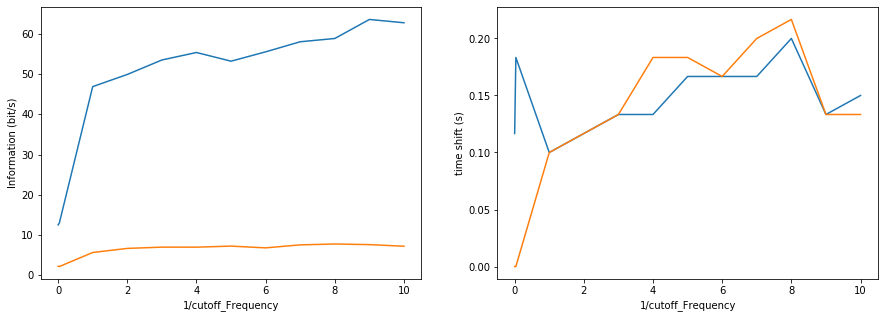

In [23]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
# Fc_list[-1] = 100
# Fc_list[-1] = np.Inf

receprocal_Fc_list = 1./Fc_list
receprocal_Fc_list[-1] = 0
ax2.plot(receprocal_Fc_list,peak_HeightnPos['MI_tr'][0, :])
ax2.plot(receprocal_Fc_list,peak_HeightnPos['MI_rr'][0, :])
ax2.set_xlabel('1/cutoff_Frequency')
ax2.set_ylabel('Information (bit/s)')

ax3.plot(receprocal_Fc_list, peak_HeightnPos['MI_tr'][1, :])
ax3.plot(receprocal_Fc_list, peak_HeightnPos['MI_rr'][1, :])
ax3.set_xlabel('1/cutoff_Frequency')
ax3.set_ylabel('time shift (s)')

fig.set_size_inches(15, 5)

smaller cutoff frequency -> flatter x (stimulus) -> 

# Fake Spike - 0D

## Spike generation

In [24]:
#following paremeters match x+v*0.5s
alpha = 60. #1/sec
beta =  2.
K = 30.
g = 30.

# alpha = 80.
# beta = 2.
# k = 200.
# g = 2/10.

deltat = 0.05
y_list = []
for i in range(len(x_list)):
    x = x_list[i].copy()
    v = v_list[i].copy()
    y=np.zeros(len(T_list[i]))
    z=np.zeros(len(T_list[i]))
    for j in range(len(T_list[i])-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    y_list.append(y.copy())

In [25]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i]

    theta = np.mean(y)+0.75*np.std(y)# if theta == 0 else theta
    r = NL(y, theta)
    ratio = sum(r)/(len(r)*dt*6) #if ratio == 0 else ratio  ##set mean firing rate to be 6hz
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 1)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
    
    
    Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
    counter = 0
    ty = np.zeros_like(y)
    for k in range(len(ystate_list[i])):
        counter += ystate_list[i][k]
        ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
    time_ystate_list[i], _ = EqualState(ty, cut_state_n)

## PID on x, {tr, rr} (tr:time code, rr:rate code) (event unit = bin)

In [26]:
Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, Information_list[i] = PIfunc(xstate_list[i], time_ystate_list[i], ystate_list[i], dt, window)

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\a

In [27]:
peak_HeightnPos = {}
peak_HeightnPos['MI_tr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['MI_rr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['MI_tr_rr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['CI'] = np.zeros((2, len(x_list)))
peak_HeightnPos['SI'] = np.zeros((2, len(x_list)))
peak_HeightnPos['UI_tr'] = np.zeros((2, len(x_list)))
peak_HeightnPos['UI_rr'] = np.zeros((2, len(x_list)))
for i in range(len(x_list)):
    UI_tr = np.flip(Information_list[i][('Beer','UIx')])
    UI_rr = np.flip(Information_list[i][('Beer','UIv')])
    CI = np.flip(Information_list[i][('Beer','Syn')])
    SI = np.flip(Information_list[i][('Beer','Red')])
    MI_tr = UI_tr+SI
    MI_rr = UI_rr+SI
    MI_tr_rr = UI_tr+UI_rr+SI+CI
    
    peak_HeightnPos['MI_tr'][:, i] = np.array([max(MI_tr),timeshift[np.argmax(MI_tr)]])
    peak_HeightnPos['MI_rr'][:, i] = np.array([max(MI_rr),timeshift[np.argmax(MI_rr)]])
    peak_HeightnPos['MI_tr_rr'][:, i] = np.array([max(MI_tr_rr),timeshift[np.argmax(MI_tr_rr)]])
    peak_HeightnPos['CI'][:, i] = np.array([max(CI),timeshift[np.argmax(CI)]])
    peak_HeightnPos['SI'][:, i] = np.array([max(SI),timeshift[np.argmax(SI)]])
    peak_HeightnPos['UI_tr'][:, i] = np.array([max(UI_tr),timeshift[np.argmax(UI_tr)]])
    peak_HeightnPos['UI_rr'][:, i] = np.array([max(UI_rr),timeshift[np.argmax(UI_rr)]])

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


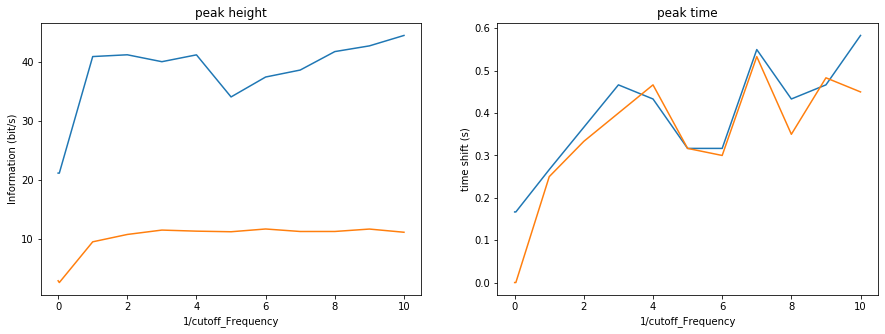

In [28]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
# Fc_list[-1] = 100
# Fc_list[-1] = np.Inf

receprocal_Fc_list = 1./Fc_list
receprocal_Fc_list[-1] = 0
ax2.plot(receprocal_Fc_list,peak_HeightnPos['MI_tr'][0, :])
ax2.plot(receprocal_Fc_list,peak_HeightnPos['MI_rr'][0, :])
ax2.set_title('peak height')
ax2.set_xlabel('1/cutoff_Frequency')
ax2.set_ylabel('Information (bit/s)')

ax3.plot(receprocal_Fc_list, peak_HeightnPos['MI_tr'][1, :])
ax3.plot(receprocal_Fc_list, peak_HeightnPos['MI_rr'][1, :])
ax3.set_title('peak time')
ax3.set_xlabel('1/cutoff_Frequency')
ax3.set_ylabel('time shift (s)')

fig.set_size_inches(15, 5)

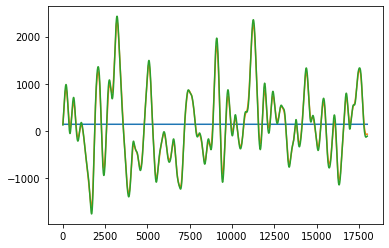

In [29]:
for i in range(3):
    plt.plot(x_list[i])